# 04: GPT Architecture - Decoder-Only Transformers

Welcome to the GPT architecture notebook! In the previous notebook, we built all the core components of a transformer:
- ✅ Positional encoding
- ✅ Multi-head attention
- ✅ Feed-forward networks
- ✅ Layer normalization
- ✅ Residual connections

But there's a crucial detail we haven't covered yet: **not all transformers are the same!**

## What You'll Learn

In this notebook, you'll discover:

1. **Encoder vs Decoder** - Different transformer variants and when to use them
2. **Causal Attention** - How to prevent "cheating" by looking ahead
3. **GPT Architecture** - The decoder-only design that powers ChatGPT
4. **Language Modeling** - Predicting the next word in a sequence
5. **Text Generation** - Making GPT write coherent text

## The Big Picture: GPT as a Text Completion Engine

At its core, GPT is incredibly simple:

```
Input:  "The weather today is"
Output: "sunny and warm"
```

GPT learns to predict what comes next. That's it!

But this simple task, when trained on massive amounts of text, creates a model that can:
- Answer questions
- Write stories
- Translate languages
- Write code
- And much more!

Let's understand how it works!

---

# Setup

In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Add src to path
sys.path.append(os.path.abspath('../src'))
from utils import (
    set_style, 
    create_causal_mask, 
    visualize_causal_mask,
    softmax,
    print_tensor_info,
    plot_attention_weights
)

set_style()
np.random.seed(42)
torch.manual_seed(42)

print("✓ Setup complete!")

✓ Setup complete!


# Part 1: Encoder vs Decoder

## The Original Transformer

The 2017 "Attention Is All You Need" paper introduced a transformer with **two parts**:

```
┌─────────────┐       ┌─────────────┐
│   ENCODER   │  →    │   DECODER   │
│ (English)   │       │  (French)   │
└─────────────┘       └─────────────┘
   Bidirectional         Causal
```

This design was for **translation**: encoder understands the source language, decoder generates the target language.

## But We Don't Always Need Both!

Modern transformers come in three flavors:

### 1. Encoder-Only (BERT)
```
Input: "The [MASK] sat on the mat"
Task:  Predict what [MASK] is
```

**Use case**: Understanding, classification, filling in blanks

**Attention**: **Bidirectional** - each word can see ALL other words (including future ones)

**Examples**: BERT, RoBERTa (used for search, classification)

### 2. Decoder-Only (GPT)
```
Input: "The cat sat on the"
Task:  Predict what comes next
```

**Use case**: Generation, completion, chat

**Attention**: **Causal** - each word can only see PREVIOUS words (not future ones)

**Examples**: GPT-2, GPT-3, GPT-4, Claude, LLaMA

### 3. Encoder-Decoder (T5)
```
Input (Encoder):  "Translate: Hello"
Output (Decoder): "Hola"
```

**Use case**: Translation, summarization, question answering

**Examples**: T5, BART (used for translation, summarization)

## The Key Difference: Bidirectional vs Causal Attention

### Analogy: The Library Metaphor

**Encoder (BERT) = Reading a Book**
```
You have the whole book in front of you.
Want to understand "it" in Chapter 5?
→ Look back at Chapter 3 ✓
→ Look ahead to Chapter 7 ✓
→ See everything to understand context!
```

**Decoder (GPT) = Writing a Story**
```
You're writing page by page.
Currently writing page 10.
→ Can see pages 1-9 (what you wrote) ✓
→ Cannot see page 11 (not written yet) ✗
→ Must predict what comes next!
```

## Comparison Table

| Feature | Encoder (BERT) | Decoder (GPT) |
|---------|----------------|---------------|
| **Attention Type** | Bidirectional | Causal |
| **Can See Future?** | Yes | No |
| **Primary Task** | Understanding | Generating |
| **Training** | Masked language model | Next token prediction |
| **Good For** | Classification, Q&A | Text generation, chat |
| **Examples** | BERT, RoBERTa | GPT-3, GPT-4, Claude |

## Let's Visualize the Difference

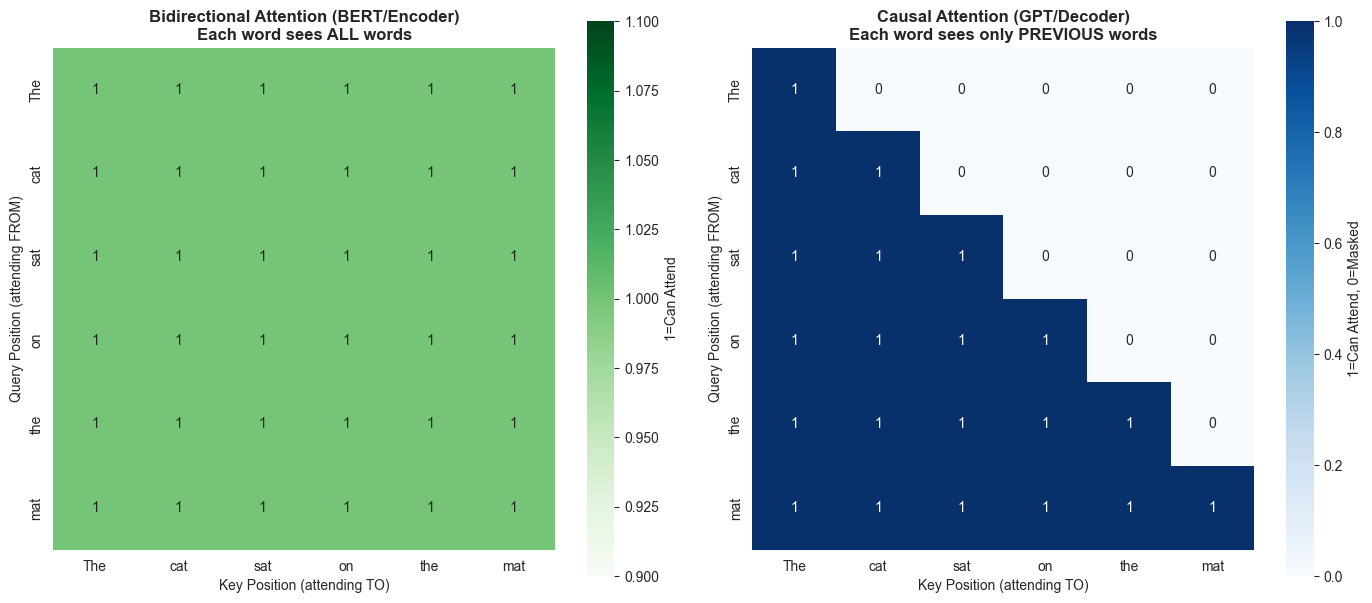


📊 Key Insight:
  Left (BERT):  'sat' can see all words → understands full context
  Right (GPT):  'sat' can only see ['The', 'cat', 'sat'] → must predict 'on' next


In [2]:
# Example sentence
tokens = ["The", "cat", "sat", "on", "the", "mat"]
seq_len = len(tokens)

# Bidirectional attention (BERT) - all positions can attend to all others
bidirectional_mask = np.ones((seq_len, seq_len))

# Causal attention (GPT) - can only attend to current and previous positions
causal_mask = create_causal_mask(seq_len)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bidirectional (Encoder/BERT)
sns.heatmap(bidirectional_mask, 
            annot=True, 
            fmt='.0f', 
            cmap='Greens',
            xticklabels=tokens,
            yticklabels=tokens,
            cbar_kws={'label': '1=Can Attend'},
            ax=axes[0],
            square=True)
axes[0].set_title('Bidirectional Attention (BERT/Encoder)\nEach word sees ALL words', 
                  fontweight='bold', fontsize=12)
axes[0].set_xlabel('Key Position (attending TO)', fontsize=10)
axes[0].set_ylabel('Query Position (attending FROM)', fontsize=10)

# Causal (Decoder/GPT)
sns.heatmap(causal_mask, 
            annot=True, 
            fmt='.0f', 
            cmap='Blues',
            xticklabels=tokens,
            yticklabels=tokens,
            cbar_kws={'label': '1=Can Attend, 0=Masked'},
            ax=axes[1],
            square=True)
axes[1].set_title('Causal Attention (GPT/Decoder)\nEach word sees only PREVIOUS words', 
                  fontweight='bold', fontsize=12)
axes[1].set_xlabel('Key Position (attending TO)', fontsize=10)
axes[1].set_ylabel('Query Position (attending FROM)', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 Key Insight:")
print("  Left (BERT):  'sat' can see all words → understands full context")
print("  Right (GPT):  'sat' can only see ['The', 'cat', 'sat'] → must predict 'on' next")

## Why Causal Matters for Generation

### The Problem Without Causal Masking

Imagine training a model to predict the next word:

```
Training example: "The cat sat on the mat"
Task: Predict each next word
```

**Without causal masking** (bidirectional):
```
Position 2 predicting next word:
  Input: "The cat sat on the mat"
  Can see: ALL words including "sat"
  Predicts: "sat" ✓ (cheating! It can see the answer!)
```

**With causal masking**:
```
Position 2 predicting next word:
  Input: "The cat sat on the mat"
  Can see: Only "The cat"
  Predicts: "sat" (actually learning!)
```

### Analogy: The Mystery Novel

**Wrong way (bidirectional):**
```
1. Read the last page to see who the killer is
2. Then "predict" the killer while reading
3. You're always right! But you learned nothing.
```

**Right way (causal):**
```
1. Read page by page, in order
2. Make guesses based only on what you've read so far
3. Sometimes wrong, but actually learning to predict!
```

---

# Part 2: Causal Attention in Detail

## The Core Idea

When predicting the next word, GPT must only use information from **current and previous** positions.

Example with "The cat sat on the mat":

```
Predicting after "The":          Can see: ["The"]                     → Predict "cat"
Predicting after "The cat":      Can see: ["The", "cat"]               → Predict "sat"
Predicting after "The cat sat":  Can see: ["The", "cat", "sat"]       → Predict "on"
...
```

## How It Works: The Causal Mask

Remember attention from notebook 02:

```
scores = Q @ K.T / √d_k
attention_weights = softmax(scores)
output = attention_weights @ V
```

To make it causal, we **mask future positions** before the softmax:

```
scores = Q @ K.T / √d_k
scores = mask_future(scores)     ← New! Set future positions to -∞
attention_weights = softmax(scores)
output = attention_weights @ V
```

## The Masking Trick

The mask is a **lower triangular matrix**:

```
[[1, 0, 0, 0],     1 = Can attend
 [1, 1, 0, 0],     0 = Cannot attend (future)
 [1, 1, 1, 0],
 [1, 1, 1, 1]]
```

We apply it like this:

```python
# Where mask is 0, set scores to -∞ (or very negative number like -1e9)
scores = scores.masked_fill(mask == 0, -1e9)

# After softmax, -∞ becomes probability 0
# So future positions get 0 attention weight!
```

## Let's Implement It

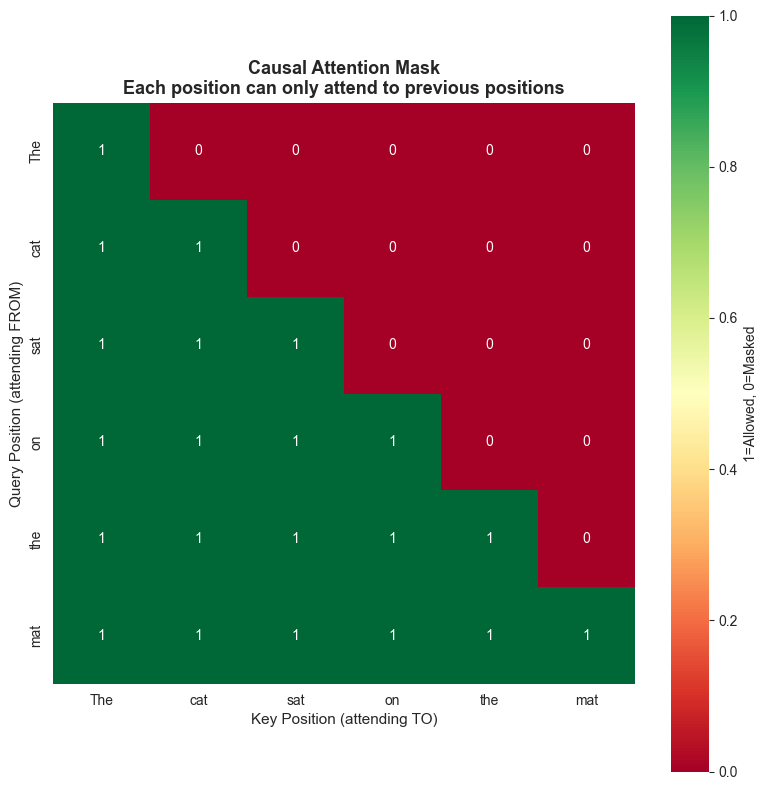


📖 Reading the mask:
  Row 0 ('The'):   Can attend to ['The'] only
  Row 1 ('cat'):   Can attend to ['The', 'cat']
  Row 2 ('sat'):   Can attend to ['The', 'cat', 'sat']
  Row 5 ('mat'):   Can attend to all previous words

  Notice: Diagonal and below = 1 (allowed), Above diagonal = 0 (masked)


In [3]:
def create_causal_mask_demo(seq_len):
    """
    Create a causal (look-ahead) mask.
    
    Args:
        seq_len: Length of the sequence
    
    Returns:
        Lower triangular mask of shape (seq_len, seq_len)
        1 = can attend, 0 = masked (cannot attend)
    """
    # np.tril creates a lower triangular matrix
    # Position i can attend to positions 0, 1, ..., i (not i+1, i+2, ...)
    mask = np.tril(np.ones((seq_len, seq_len)))
    return mask

# Visualize for our example sentence
tokens = ["The", "cat", "sat", "on", "the", "mat"]
mask = create_causal_mask_demo(len(tokens))

plt.figure(figsize=(8, 8))
sns.heatmap(mask,
            annot=True,
            fmt='.0f',
            cmap='RdYlGn',
            xticklabels=tokens,
            yticklabels=tokens,
            cbar_kws={'label': '1=Allowed, 0=Masked'},
            square=True)
plt.title('Causal Attention Mask\nEach position can only attend to previous positions',
          fontweight='bold', fontsize=13)
plt.xlabel('Key Position (attending TO)', fontsize=11)
plt.ylabel('Query Position (attending FROM)', fontsize=11)
plt.tight_layout()
plt.show()

print("\n📖 Reading the mask:")
print("  Row 0 ('The'):   Can attend to ['The'] only")
print("  Row 1 ('cat'):   Can attend to ['The', 'cat']")
print("  Row 2 ('sat'):   Can attend to ['The', 'cat', 'sat']")
print("  Row 5 ('mat'):   Can attend to all previous words")
print("\n  Notice: Diagonal and below = 1 (allowed), Above diagonal = 0 (masked)")

## Applying the Mask to Attention Scores

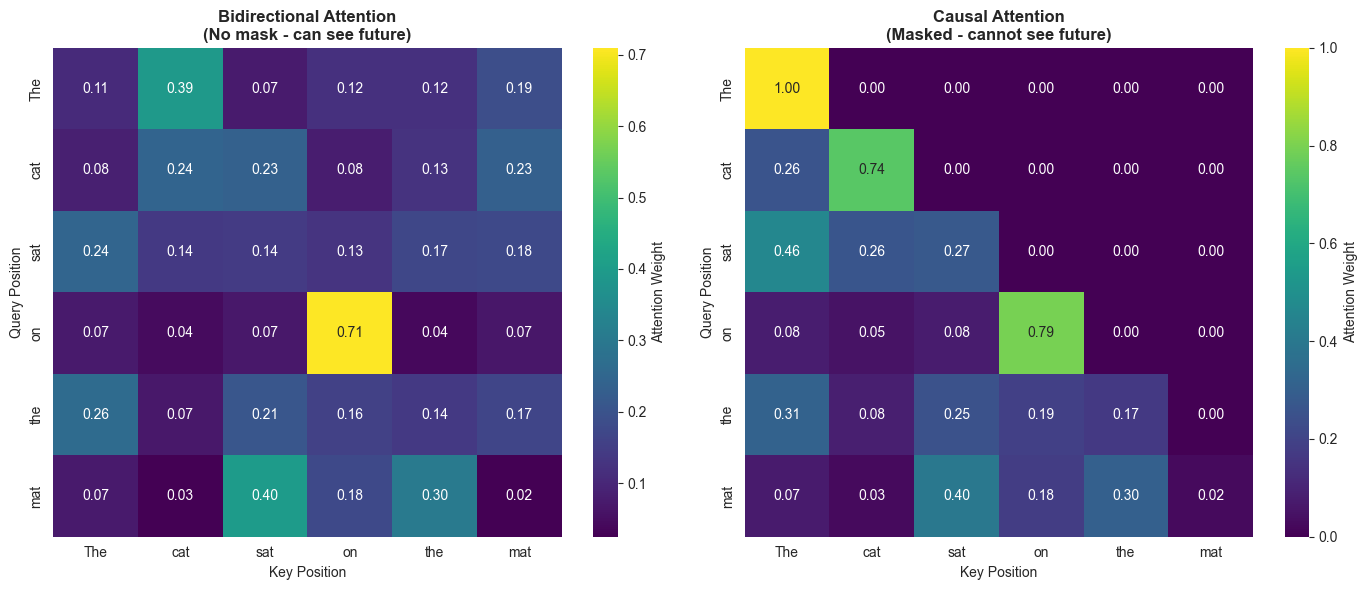


🔍 Notice the difference:
  Left:  Attention weights everywhere (bidirectional)
  Right: Upper triangle is all zeros! (causal - future masked out)

  Row 2 ('sat') in right plot:
    Attention to ['The', 'cat', 'sat']: [0.46351423 0.26288124 0.27360453]
    Attention to future ['on', 'the', 'mat']: [0. 0. 0.] (all zeros!)


In [4]:
def masked_attention_numpy(Q, K, V, mask=None):
    """
    Compute masked attention.
    
    Args:
        Q: Query matrix of shape (seq_len, d_k)
        K: Key matrix of shape (seq_len, d_k)
        V: Value matrix of shape (seq_len, d_v)
        mask: Optional mask of shape (seq_len, seq_len)
              1 = can attend, 0 = masked
    
    Returns:
        output: Attention output of shape (seq_len, d_v)
        attention_weights: Attention weights of shape (seq_len, seq_len)
    """
    d_k = Q.shape[-1]
    
    # 1. Compute attention scores
    scores = Q @ K.T / np.sqrt(d_k)  # Shape: (seq_len, seq_len)
    
    # 2. Apply mask (if provided)
    if mask is not None:
        # Set masked positions to very negative number
        # After softmax, these become ~0 probability
        scores = np.where(mask == 1, scores, -1e9)
    
    # 3. Softmax to get attention weights
    attention_weights = softmax(scores, axis=-1)
    
    # 4. Apply attention weights to values
    output = attention_weights @ V
    
    return output, attention_weights

# Test it with a simple example
seq_len = 6
d_k = 4
d_v = 4

np.random.seed(42)
Q = np.random.randn(seq_len, d_k)
K = np.random.randn(seq_len, d_k)
V = np.random.randn(seq_len, d_v)

# Create causal mask
causal_mask = create_causal_mask_demo(seq_len)

# Compute attention WITHOUT mask (bidirectional)
output_no_mask, attn_no_mask = masked_attention_numpy(Q, K, V, mask=None)

# Compute attention WITH mask (causal)
output_with_mask, attn_with_mask = masked_attention_numpy(Q, K, V, mask=causal_mask)

# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Without mask
sns.heatmap(attn_no_mask,
            annot=True,
            fmt='.2f',
            cmap='viridis',
            xticklabels=tokens,
            yticklabels=tokens,
            ax=axes[0],
            cbar_kws={'label': 'Attention Weight'})
axes[0].set_title('Bidirectional Attention\n(No mask - can see future)', 
                  fontweight='bold')
axes[0].set_xlabel('Key Position')
axes[0].set_ylabel('Query Position')

# With mask
sns.heatmap(attn_with_mask,
            annot=True,
            fmt='.2f',
            cmap='viridis',
            xticklabels=tokens,
            yticklabels=tokens,
            ax=axes[1],
            cbar_kws={'label': 'Attention Weight'})
axes[1].set_title('Causal Attention\n(Masked - cannot see future)', 
                  fontweight='bold')
axes[1].set_xlabel('Key Position')
axes[1].set_ylabel('Query Position')

plt.tight_layout()
plt.show()

print("\n🔍 Notice the difference:")
print("  Left:  Attention weights everywhere (bidirectional)")
print("  Right: Upper triangle is all zeros! (causal - future masked out)")
print("\n  Row 2 ('sat') in right plot:")
print(f"    Attention to ['The', 'cat', 'sat']: {attn_with_mask[2, :3]}")
print(f"    Attention to future ['on', 'the', 'mat']: {attn_with_mask[2, 3:]} (all zeros!)")

## Why -1e9 and Not Just 0?

You might wonder: why set masked positions to -1e9 instead of just 0?

**Answer**: Because of where we apply the mask - BEFORE the softmax!

```python
# Wrong: Setting scores to 0
scores = [2.0, 1.0, 0.0]  # 0 for masked position
softmax(scores) = [0.53, 0.33, 0.14]  # Oops! Still has 0.14 weight!

# Right: Setting scores to -∞ (or -1e9)
scores = [2.0, 1.0, -1e9]  # Very negative for masked
softmax(scores) = [0.73, 0.27, ~0.0]  # Perfect! ~0 weight
```

The softmax function makes very negative values approach probability 0!

---

# Part 3: GPT Architecture

## The Key Insight

GPT is remarkably simple:

**GPT = Transformer Block + Causal Mask**

That's it! We already know transformer blocks from notebook 03. We just learned causal masking. Now we combine them!

## Architecture Diagram

```
Input Text
    ↓
Token Embeddings (map words to vectors)
    ↓
  + Positional Encoding (add position info)
    ↓
┌─────────────────────────────┐
│   GPT Block 1               │
│   - Causal Self-Attention   │ ← Causal mask here!
│   - Feed-Forward            │
│   - LayerNorm + Residuals   │
└─────────────────────────────┘
    ↓
┌─────────────────────────────┐
│   GPT Block 2               │
│   ...                       │
└─────────────────────────────┘
    ↓
    ... (repeat N times)
    ↓
┌─────────────────────────────┐
│   GPT Block N               │
└─────────────────────────────┘
    ↓
Output Projection (map back to vocabulary)
    ↓
Probability distribution over next words
```

## Building on Notebook 03

From the previous notebook, we reuse:
- ✅ Positional Encoding
- ✅ Feed-Forward Network
- ✅ Layer Normalization
- ✅ Residual Connections

**What's new**:
- Adding **causal mask** to the attention mechanism
- Output projection to vocabulary (for next word prediction)

## Implementation

Let's build the components step by step.

### Step 1: Positional Encoding (Reused from Notebook 03)

In [5]:
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding (same as notebook 03)."""
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: Embeddings of shape (batch_size, seq_len, d_model)
        Returns:
            x + positional encoding
        """
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :]

print("✓ PositionalEncoding defined")

✓ PositionalEncoding defined


### Step 2: Feed-Forward Network (Reused from Notebook 03)

In [6]:
class FeedForward(nn.Module):
    """Position-wise feed-forward network (same as notebook 03)."""
    
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Expand: d_model → d_ff
        x = self.linear1(x)
        # Non-linearity
        x = F.relu(x)
        # Dropout
        x = self.dropout(x)
        # Compress: d_ff → d_model
        x = self.linear2(x)
        return x

print("✓ FeedForward defined")

✓ FeedForward defined


### Step 3: Causal Multi-Head Attention (NEW!)

In [7]:
class CausalMultiHeadAttention(nn.Module):
    """Multi-head attention with causal masking for GPT."""
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Args:
            x: Input of shape (batch_size, seq_len, d_model)
        
        Returns:
            Output of shape (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.size()
        
        # 1. Linear projections and split into heads
        # Shape: (batch_size, seq_len, d_model) → (batch_size, num_heads, seq_len, d_k)
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # 2. Scaled dot-product attention with causal mask
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        # Shape: (batch_size, num_heads, seq_len, seq_len)
        
        # 3. Apply causal mask
        # Create mask: lower triangular matrix
        causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=x.device))
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions
        # Shape: (1, 1, seq_len, seq_len)
        
        # Mask future positions (set to -inf, which becomes ~0 after softmax)
        scores = scores.masked_fill(causal_mask == 0, -1e9)
        
        # 4. Softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # 5. Apply attention to values
        attn_output = torch.matmul(attention_weights, V)
        # Shape: (batch_size, num_heads, seq_len, d_k)
        
        # 6. Concatenate heads and apply output projection
        # (batch_size, num_heads, seq_len, d_k) → (batch_size, seq_len, d_model)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        
        # Final linear projection
        output = self.W_o(attn_output)
        
        return output

# Test it
d_model = 64
num_heads = 8
batch_size = 2
seq_len = 10

causal_attn = CausalMultiHeadAttention(d_model, num_heads)
x = torch.randn(batch_size, seq_len, d_model)
output = causal_attn(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print("\n✓ Causal Multi-Head Attention working!")

Input shape:  torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])

✓ Causal Multi-Head Attention working!


### Step 4: GPT Block (Transformer Block with Causal Attention)

In [8]:
class GPTBlock(nn.Module):
    """
    A single GPT transformer block.
    
    Architecture:
      1. Causal multi-head self-attention + residual + layer norm
      2. Feed-forward network + residual + layer norm
    """
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        
        # Causal multi-head attention
        self.attention = CausalMultiHeadAttention(d_model, num_heads, dropout)
        
        # Feed-forward network
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        # Layer normalization (we use pre-norm: normalize before sublayer)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Args:
            x: Input of shape (batch_size, seq_len, d_model)
        
        Returns:
            Output of shape (batch_size, seq_len, d_model)
        """
        # Pre-norm architecture (more stable than post-norm)
        
        # 1. Causal self-attention with residual
        # Normalize → attention → dropout → residual
        attn_output = self.attention(self.norm1(x))
        x = x + self.dropout(attn_output)  # Residual connection
        
        # 2. Feed-forward with residual
        # Normalize → FFN → dropout → residual
        ffn_output = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ffn_output)  # Residual connection
        
        return x

# Test it
gpt_block = GPTBlock(d_model=64, num_heads=8, d_ff=256)
x = torch.randn(2, 10, 64)
output = gpt_block(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print("\n✓ GPT Block working!")

# Count parameters
num_params = sum(p.numel() for p in gpt_block.parameters())
print(f"\nParameters in one GPT block: {num_params:,}")

Input shape:  torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])

✓ GPT Block working!

Parameters in one GPT block: 49,984


## Comparison: Regular Transformer Block vs GPT Block

| Feature | Regular Transformer (BERT) | GPT Block |
|---------|---------------------------|------------|
| Attention Type | Bidirectional | **Causal** |
| Mask | None or padding mask | **Causal mask** (lower triangular) |
| Can see future? | Yes | **No** |
| Use case | Understanding, classification | **Generation, completion** |

The **only** difference is the causal mask in attention!

---

# Part 4: Language Modeling

## What is Language Modeling?

**Language Modeling** = Predicting the next word given previous words

### The Core Task

```
Input:  "The cat sat on the"
Output: Probability distribution over all possible next words

Possible next words:
  "mat"     → 60% probability  ✓ Most likely
  "floor"   → 20% probability
  "chair"   → 10% probability
  "roof"    → 5% probability
  "moon"    → 0.1% probability
  ...
```

The model learns these probabilities from training data!

## Training: Learning from Examples

### How It Works

Given a sentence: **"The cat sat on the mat"**

We create multiple training examples:

```
Example 1:
  Input:  ["The"]
  Target: "cat"

Example 2:
  Input:  ["The", "cat"]
  Target: "sat"

Example 3:
  Input:  ["The", "cat", "sat"]
  Target: "on"

Example 4:
  Input:  ["The", "cat", "sat", "on"]
  Target: "the"

Example 5:
  Input:  ["The", "cat", "sat", "on", "the"]
  Target: "mat"
```

From **one sentence**, we get **many training examples**! This is why language models can learn from lots of text efficiently.

### The Clever Trick: Parallel Training

We can train on ALL positions at once thanks to the causal mask:

```
Input:  ["The", "cat", "sat", "on", "the", "mat"]
Target: ["cat", "sat", "on", "the", "mat", <END>]

Position 0: Predicts "cat" using ["The"]
Position 1: Predicts "sat" using ["The", "cat"]
Position 2: Predicts "on" using ["The", "cat", "sat"]
...
```

All predictions computed in **one forward pass**! The causal mask ensures position i can only see positions 0 to i.

## The Loss Function: Cross-Entropy

How do we measure if predictions are good?

### What the Model Outputs

For each position, the model outputs a **probability distribution** over all words in the vocabulary:

```python
# Example: vocab_size = 50,000 words
model_output = [0.001, 0.002, ..., 0.6, ..., 0.001]  # Probabilities sum to 1
                                      ↑
                                   "mat" (correct word)
```

### Cross-Entropy Loss

**Goal**: Make the probability of the correct word as high as possible.

**Formula**:
```
Loss = -log(probability of correct word)
```

**Why this works**:
```
If model assigns 90% to correct word: Loss = -log(0.9)  = 0.10  ✓ Small loss!
If model assigns 50% to correct word: Loss = -log(0.5)  = 0.69
If model assigns 10% to correct word: Loss = -log(0.1)  = 2.30  ✗ Large loss!
If model assigns 1% to correct word:  Loss = -log(0.01) = 4.60  ✗✗ Very large loss!
```

**Training** adjusts model parameters to minimize this loss.

## Let's Visualize This

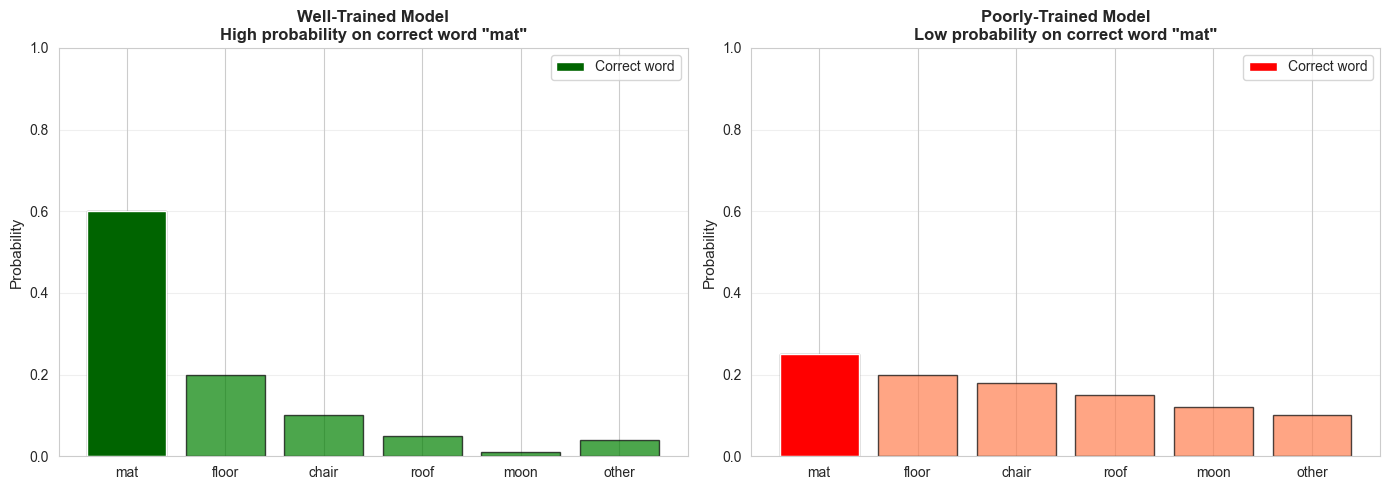


📊 Cross-Entropy Loss:
  Well-trained model:  P('mat') = 0.60 → Loss = 0.511 ✓
  Poorly-trained model: P('mat') = 0.25 → Loss = 1.386 ✗

  Lower loss = better model!
  Training tries to minimize this loss.


In [9]:
# Simulate model predictions for "The cat sat on the ?"
# Vocabulary: ["mat", "floor", "chair", "roof", "moon", "other"]
vocab = ["mat", "floor", "chair", "roof", "moon", "other"]
vocab_size = len(vocab)

# Case 1: Well-trained model (high probability on correct word)
good_probs = np.array([0.60, 0.20, 0.10, 0.05, 0.01, 0.04])
# Case 2: Poorly-trained model (more uniform distribution)
bad_probs = np.array([0.25, 0.20, 0.18, 0.15, 0.12, 0.10])

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Well-trained model
axes[0].bar(vocab, good_probs, color='green', alpha=0.7, edgecolor='black')
axes[0].bar([vocab[0]], [good_probs[0]], color='darkgreen', label='Correct word')  # Highlight correct
axes[0].set_ylabel('Probability', fontsize=11)
axes[0].set_title('Well-Trained Model\nHigh probability on correct word "mat"', 
                  fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Poorly-trained model
axes[1].bar(vocab, bad_probs, color='coral', alpha=0.7, edgecolor='black')
axes[1].bar([vocab[0]], [bad_probs[0]], color='red', label='Correct word')  # Highlight correct
axes[1].set_ylabel('Probability', fontsize=11)
axes[1].set_title('Poorly-Trained Model\nLow probability on correct word "mat"', 
                  fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Compute losses
good_loss = -np.log(good_probs[0])  # Loss for "mat" prediction
bad_loss = -np.log(bad_probs[0])

print(f"\n📊 Cross-Entropy Loss:")
print(f"  Well-trained model:  P('mat') = {good_probs[0]:.2f} → Loss = {good_loss:.3f} ✓")
print(f"  Poorly-trained model: P('mat') = {bad_probs[0]:.2f} → Loss = {bad_loss:.3f} ✗")
print(f"\n  Lower loss = better model!")
print(f"  Training tries to minimize this loss.")

## Why Language Modeling is Powerful

Learning to predict the next word seems simple, but it forces the model to learn:

### 1. Grammar
```
"The cat ___" → must be a verb, not a noun
Learns: "sat", "ran" are likely; "the", "happy" are not
```

### 2. Facts
```
"The capital of France is ___"
Learns: "Paris" is the answer from seeing it many times in training data
```

### 3. Reasoning
```
"If it's raining, you should bring an ___"
Learns: "umbrella" is a logical completion
```

### 4. Context
```
"The bank":
  - "... gave me a loan" → financial bank
  - "... of the river" → riverside bank
Learns to distinguish based on context!
```

**This is why GPT can do so much with "just" next-word prediction!**

---

# Part 5: Text Generation

## How GPT Generates Text

Now we know GPT predicts the next word. But how do we use this to generate multiple words?

### Autoregressive Generation

**Autoregressive** = Use your own output as input for the next step

```
Step 1: Input = "The"          → Predict "cat"      → Output = "The cat"
Step 2: Input = "The cat"      → Predict "sat"      → Output = "The cat sat"
Step 3: Input = "The cat sat"  → Predict "on"       → Output = "The cat sat on"
Step 4: Input = "The cat sat on" → Predict "the"    → Output = "The cat sat on the"
Step 5: Input = "The cat sat on the" → Predict "mat" → Output = "The cat sat on the mat"
```

Each prediction is added to the input for the next prediction!

## Sampling Strategies

The model outputs a **probability distribution**, not a single word. How do we choose which word to actually generate?

### 1. Greedy Decoding

**Always pick the word with highest probability**

```python
next_word = argmax(probabilities)
```

**Pros**:
- ✓ Deterministic (same input → same output)
- ✓ Safest choice

**Cons**:
- ✗ Boring! Always picks the most common completion
- ✗ Can get stuck in repetitive loops
- ✗ No creativity

### 2. Random Sampling

**Sample from the probability distribution**

```python
next_word = random_choice(words, probabilities)
```

**Pros**:
- ✓ Creative and diverse
- ✓ Different outputs each time

**Cons**:
- ✗ Can be too random and incoherent
- ✗ Might pick unlikely words

### 3. Temperature Sampling

**Control the randomness**

Temperature (T) adjusts the probability distribution before sampling:

```python
# Apply temperature
logits = logits / temperature
probabilities = softmax(logits)

# Then sample
next_word = random_choice(words, probabilities)
```

**Effect of temperature**:

- **T = 0.1** (low): Almost greedy, very safe
  ```
  Original: [0.6, 0.2, 0.1, 0.05, 0.05]
  After:    [0.95, 0.03, 0.01, 0.005, 0.005]  ← Sharper!
  ```

- **T = 1.0** (default): Normal sampling
  ```
  Original: [0.6, 0.2, 0.1, 0.05, 0.05]
  After:    [0.6, 0.2, 0.1, 0.05, 0.05]  ← Unchanged
  ```

- **T = 2.0** (high): Very random, creative
  ```
  Original: [0.6, 0.2, 0.1, 0.05, 0.05]
  After:    [0.35, 0.22, 0.17, 0.13, 0.13]  ← Flatter!
  ```

**The sweet spot**: T ≈ 0.7-0.9 for chatbots (coherent but creative)

## Let's Visualize Temperature Effects

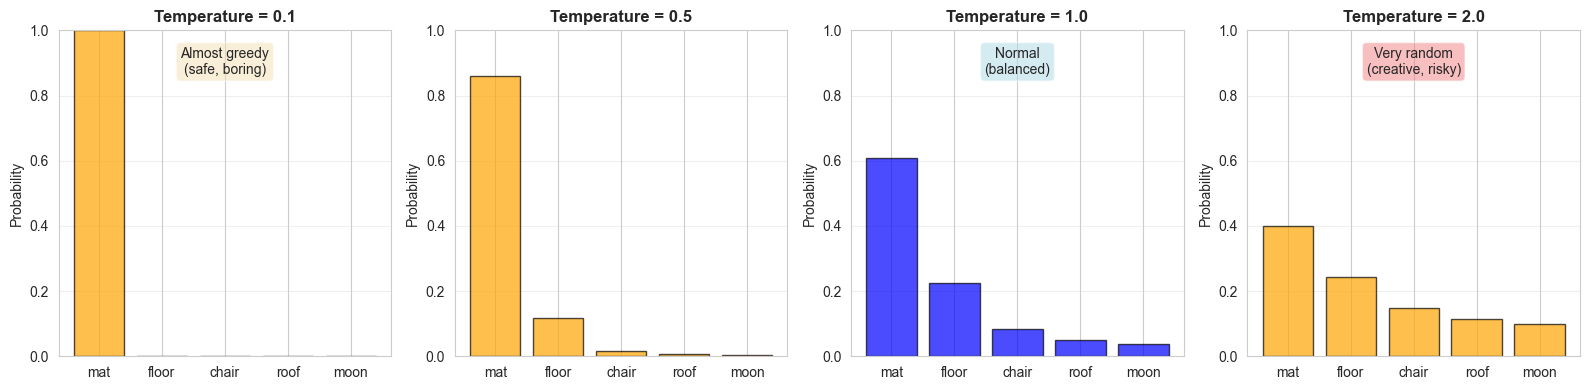


🌡️ Temperature Controls Randomness:
  T=0.1: Top word probability = 1.000 (almost certain)
  T=1.0: Top word probability = 0.607 (normal)
  T=2.0: Top word probability = 0.399 (more uncertain)

  Lower T = More focused on top choices
  Higher T = More exploration of alternatives


In [10]:
def apply_temperature(logits, temperature):
    """
    Apply temperature scaling to logits.
    
    Args:
        logits: Raw scores before softmax
        temperature: Temperature parameter (> 0)
    
    Returns:
        Probabilities after temperature scaling
    """
    # Scale logits by temperature
    scaled_logits = logits / temperature
    
    # Apply softmax
    probs = softmax(scaled_logits)
    
    return probs

# Example logits (raw scores before softmax)
vocab = ["mat", "floor", "chair", "roof", "moon"]
logits = np.array([3.0, 2.0, 1.0, 0.5, 0.2])  # Higher = more likely

# Try different temperatures
temperatures = [0.1, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, len(temperatures), figsize=(16, 4))

for i, temp in enumerate(temperatures):
    probs = apply_temperature(logits, temp)
    
    # Plot
    axes[i].bar(vocab, probs, alpha=0.7, edgecolor='black',
                color='blue' if temp == 1.0 else 'orange')
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel('Probability')
    axes[i].set_title(f'Temperature = {temp}', fontweight='bold', fontsize=12)
    axes[i].grid(axis='y', alpha=0.3)
    
    # Add annotation
    if temp == 0.1:
        axes[i].text(0.5, 0.95, 'Almost greedy\n(safe, boring)', 
                    ha='center', va='top', transform=axes[i].transAxes,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    elif temp == 1.0:
        axes[i].text(0.5, 0.95, 'Normal\n(balanced)', 
                    ha='center', va='top', transform=axes[i].transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    elif temp == 2.0:
        axes[i].text(0.5, 0.95, 'Very random\n(creative, risky)', 
                    ha='center', va='top', transform=axes[i].transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n🌡️ Temperature Controls Randomness:")
print(f"  T=0.1: Top word probability = {apply_temperature(logits, 0.1)[0]:.3f} (almost certain)")
print(f"  T=1.0: Top word probability = {apply_temperature(logits, 1.0)[0]:.3f} (normal)")
print(f"  T=2.0: Top word probability = {apply_temperature(logits, 2.0)[0]:.3f} (more uncertain)")
print("\n  Lower T = More focused on top choices")
print("  Higher T = More exploration of alternatives")

## Implementation: Text Generation Function

In [11]:
def generate_next_token(model, input_ids, temperature=1.0):
    """
    Generate the next token using the model.
    
    Args:
        model: GPT model
        input_ids: Input token IDs of shape (batch_size, seq_len)
        temperature: Sampling temperature
    
    Returns:
        Next token ID
    """
    # Get model predictions
    with torch.no_grad():
        logits = model(input_ids)  # Shape: (batch_size, seq_len, vocab_size)
    
    # Get logits for the last position (next token prediction)
    next_token_logits = logits[:, -1, :]  # Shape: (batch_size, vocab_size)
    
    # Apply temperature
    next_token_logits = next_token_logits / temperature
    
    # Convert to probabilities
    probs = F.softmax(next_token_logits, dim=-1)
    
    # Sample from the distribution
    next_token = torch.multinomial(probs, num_samples=1)
    
    return next_token

def generate_text(model, prompt_ids, max_new_tokens=50, temperature=1.0):
    """
    Generate text autoregressively.
    
    Args:
        model: GPT model
        prompt_ids: Initial prompt token IDs of shape (1, prompt_len)
        max_new_tokens: Maximum number of tokens to generate
        temperature: Sampling temperature
    
    Returns:
        Generated token IDs of shape (1, prompt_len + max_new_tokens)
    """
    model.eval()
    
    # Start with the prompt
    generated = prompt_ids.clone()
    
    # Generate tokens one by one
    for _ in range(max_new_tokens):
        # Generate next token
        next_token = generate_next_token(model, generated, temperature)
        
        # Append to generated sequence
        generated = torch.cat([generated, next_token], dim=1)
        
        # Optional: Stop if we generate an end token
        # if next_token.item() == END_TOKEN_ID:
        #     break
    
    return generated

print("✓ Text generation functions defined!")
print("\n📝 Key idea:")
print("  1. Start with prompt")
print("  2. Predict next token")
print("  3. Add it to the sequence")
print("  4. Repeat from step 2")
print("\n  This is how ChatGPT generates responses, one token at a time!")

✓ Text generation functions defined!

📝 Key idea:
  1. Start with prompt
  2. Predict next token
  3. Add it to the sequence
  4. Repeat from step 2

  This is how ChatGPT generates responses, one token at a time!


## Stopping Criteria

When does generation stop?

1. **Max length reached**: Generated `max_new_tokens` tokens
2. **End token**: Model generates a special `<END>` token
3. **User interruption**: User stops the generation

ChatGPT uses all of these!

---

# Part 6: Complete Mini GPT

Now let's put everything together into a complete GPT model!

## Full Architecture

In [12]:
class MiniGPT(nn.Module):
    """
    A complete mini GPT model.
    
    Architecture:
      Token Embedding → + Positional Encoding → [GPT Blocks × N] → Output Projection
    """
    
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout=0.1):
        """
        Args:
            vocab_size: Size of the vocabulary
            d_model: Embedding dimension
            num_heads: Number of attention heads
            num_layers: Number of GPT blocks
            d_ff: Feed-forward hidden dimension
            max_seq_len: Maximum sequence length
            dropout: Dropout probability
        """
        super().__init__()
        
        self.d_model = d_model
        
        # Token embeddings (map token IDs to vectors)
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)
        
        # Stack of GPT blocks
        self.blocks = nn.ModuleList([
            GPTBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Final layer norm
        self.ln_final = nn.LayerNorm(d_model)
        
        # Output projection (map back to vocabulary)
        self.output_projection = nn.Linear(d_model, vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        """Initialize weights with small random values."""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, token_ids):
        """
        Forward pass.
        
        Args:
            token_ids: Input token IDs of shape (batch_size, seq_len)
        
        Returns:
            Logits of shape (batch_size, seq_len, vocab_size)
        """
        # 1. Token embeddings
        x = self.token_embedding(token_ids)  # (batch_size, seq_len, d_model)
        
        # 2. Add positional encoding
        x = self.pos_encoding(x)
        
        # 3. Dropout
        x = self.dropout(x)
        
        # 4. Pass through GPT blocks
        for block in self.blocks:
            x = block(x)
        
        # 5. Final layer norm
        x = self.ln_final(x)
        
        # 6. Project to vocabulary
        logits = self.output_projection(x)  # (batch_size, seq_len, vocab_size)
        
        return logits
    
    def generate(self, prompt_ids, max_new_tokens=50, temperature=1.0):
        """
        Generate text autoregressively.
        
        Args:
            prompt_ids: Prompt token IDs of shape (1, prompt_len)
            max_new_tokens: Maximum tokens to generate
            temperature: Sampling temperature
        
        Returns:
            Generated token IDs
        """
        return generate_text(self, prompt_ids, max_new_tokens, temperature)

print("✓ MiniGPT defined!")

✓ MiniGPT defined!


## Create and Test MiniGPT

In [13]:
# Hyperparameters (tiny model for demo)
vocab_size = 1000      # Small vocabulary
d_model = 128         # Embedding dimension
num_heads = 8         # Attention heads
num_layers = 4        # GPT blocks
d_ff = 512           # Feed-forward dimension (4 × d_model)
max_seq_len = 256     # Maximum sequence length
dropout = 0.1

# Create model
model = MiniGPT(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_seq_len=max_seq_len,
    dropout=dropout
)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())

print(f"MiniGPT Model Created!")
print(f"\nHyperparameters:")
print(f"  Vocabulary size:  {vocab_size:,}")
print(f"  Embedding dim:    {d_model}")
print(f"  Attention heads:  {num_heads}")
print(f"  Layers:           {num_layers}")
print(f"  FFN hidden dim:   {d_ff}")
print(f"  Max seq length:   {max_seq_len}")
print(f"\nTotal parameters: {num_params:,}")

# Test forward pass
batch_size = 2
seq_len = 10
test_input = torch.randint(0, vocab_size, (batch_size, seq_len))

with torch.no_grad():
    output = model(test_input)

print(f"\nTest Forward Pass:")
print(f"  Input shape:  {test_input.shape}  (batch_size, seq_len)")
print(f"  Output shape: {output.shape}  (batch_size, seq_len, vocab_size)")
print(f"\n✓ Model is ready for training!")

MiniGPT Model Created!

Hyperparameters:
  Vocabulary size:  1,000
  Embedding dim:    128
  Attention heads:  8
  Layers:           4
  FFN hidden dim:   512
  Max seq length:   256

Total parameters: 1,050,344

Test Forward Pass:
  Input shape:  torch.Size([2, 10])  (batch_size, seq_len)
  Output shape: torch.Size([2, 10, 1000])  (batch_size, seq_len, vocab_size)

✓ Model is ready for training!


## Demo: Generate Random Text (Untrained Model)

Let's see what an **untrained** model generates (it will be gibberish, but it demonstrates the mechanics!)

In [14]:
# Create a simple prompt (random token IDs since we don't have a real tokenizer)
prompt = torch.randint(0, vocab_size, (1, 5))  # 5 random tokens as prompt

print("Generating text with untrained model...\n")
print(f"Prompt token IDs: {prompt.squeeze().tolist()}")

# Generate with different temperatures
for temp in [0.5, 1.0, 2.0]:
    generated = model.generate(prompt, max_new_tokens=10, temperature=temp)
    generated_tokens = generated.squeeze().tolist()
    
    print(f"\nTemperature {temp}:")
    print(f"  Prompt:    {generated_tokens[:5]}")
    print(f"  Generated: {generated_tokens[5:]}")

print("\n📝 Note: The output is random because the model is untrained!")
print("   After training on real text, it would generate coherent sentences.")

Generating text with untrained model...

Prompt token IDs: [929, 827, 818, 904, 906]

Temperature 0.5:
  Prompt:    [929, 827, 818, 904, 906]
  Generated: [494, 238, 585, 809, 663, 905, 650, 549, 921, 314]

Temperature 1.0:
  Prompt:    [929, 827, 818, 904, 906]
  Generated: [940, 810, 330, 609, 475, 496, 665, 945, 541, 878]

Temperature 2.0:
  Prompt:    [929, 827, 818, 904, 906]
  Generated: [564, 539, 755, 372, 387, 97, 35, 163, 3, 524]

📝 Note: The output is random because the model is untrained!
   After training on real text, it would generate coherent sentences.


## Comparison: Model Sizes

Our MiniGPT is tiny! Let's compare with real models:

| Model | Layers | d_model | Heads | Parameters |
|-------|--------|---------|-------|------------|
| **Our MiniGPT** | 4 | 128 | 8 | ~1M |
| **GPT-2 Small** | 12 | 768 | 12 | 117M |
| **GPT-2 Medium** | 24 | 1024 | 16 | 345M |
| **GPT-2 Large** | 36 | 1280 | 20 | 774M |
| **GPT-2 XL** | 48 | 1600 | 25 | 1.5B |
| **GPT-3** | 96 | 12288 | 96 | 175B |
| **GPT-4** | ??? | ??? | ??? | ~1.7T (estimated) |

The architecture is the **same**, just scaled up!

---

# Exercises

## Exercise 1: Causal Mask Exploration

1. Create a causal mask for seq_len=8
2. Visualize it with word labels
3. What happens if you transpose the mask? Why would that be wrong?

In [15]:
# Your code here


## Exercise 2: Temperature Experiments

1. Generate 10 samples with temperature=0.1
2. Generate 10 samples with temperature=2.0
3. Compare the diversity of outputs
4. What temperature would you use for:
   - Writing code?
   - Writing poetry?
   - Answering factual questions?

In [16]:
# Your code here


## Exercise 3: Bidirectional vs Causal Comparison

1. Modify `CausalMultiHeadAttention` to remove the causal mask (make it bidirectional)
2. Compare attention patterns between causal and bidirectional
3. Why would bidirectional attention be bad for text generation?

In [17]:
# Your code here


## Exercise 4: Parameter Counting

Calculate the number of parameters for:
1. GPT-2 Small (12 layers, d_model=768, 12 heads, vocab_size=50257)
2. GPT-2 Medium (24 layers, d_model=1024, 16 heads)
3. Your own custom GPT configuration

**Hint**: Parameters come from:
- Token embeddings: vocab_size × d_model
- Each GPT block
- Output projection: d_model × vocab_size

In [18]:
# Your code here


## Exercise 5 (Challenge): Top-K and Top-P Sampling

Implement advanced sampling strategies:

### Top-K Sampling
Only sample from the K most likely tokens
```python
def top_k_sampling(logits, k=40):
    # Keep only top k logits
    # Set others to -inf
    # Sample from the filtered distribution
    pass
```

### Top-P (Nucleus) Sampling
Sample from the smallest set of tokens whose cumulative probability exceeds P
```python
def top_p_sampling(logits, p=0.9):
    # Sort probabilities
    # Find smallest set with cumulative prob > p
    # Sample from that set
    pass
```

These are used in ChatGPT!

In [19]:
# Your code here


---

# Summary & Key Takeaways

## What We Learned

### 1. Encoder vs Decoder
- **Encoder (BERT)**: Bidirectional attention, for understanding
- **Decoder (GPT)**: Causal attention, for generation
- **Key difference**: Can the model see future tokens?

### 2. Causal Attention
- **Why**: Prevent "cheating" during training
- **How**: Lower triangular mask + set future to -∞
- **Result**: Position i can only attend to positions 0...i

### 3. GPT Architecture
- **Simple**: Transformer block + causal mask
- **Components**: Embeddings → Position → [GPT Blocks × N] → Output
- **Reused**: Most components from notebook 03!

### 4. Language Modeling
- **Task**: Predict next word given previous words
- **Training**: One sentence → many examples
- **Loss**: Cross-entropy (minimize -log P(correct word))
- **Power**: Forces model to learn grammar, facts, reasoning

### 5. Text Generation
- **Method**: Autoregressive (use output as next input)
- **Strategies**:
  - Greedy: Safe but boring
  - Random: Creative but chaotic
  - Temperature: Control the trade-off
- **Temperature**: Low = deterministic, High = creative

## The Big Picture

```
GPT = Decoder-only transformer
    = Transformer blocks with causal attention
    = Next-word prediction machine
    = Autoregressive text generator
```

**This simple idea powers ChatGPT, Claude, and other language models!**

## Key Equations

### Causal Mask
```python
mask = np.tril(np.ones((seq_len, seq_len)))  # Lower triangular
```

### Masked Attention
```python
scores = Q @ K.T / √d_k
scores = scores.masked_fill(mask == 0, -1e9)  # Mask future
attention = softmax(scores) @ V
```

### Cross-Entropy Loss
```python
loss = -log(P(correct_word))
```

### Temperature Sampling
```python
logits = logits / temperature
probs = softmax(logits)
next_token = sample(probs)
```

## What Makes GPT Powerful

### 1. Scale
- More parameters → more knowledge
- GPT-3: 175 billion parameters
- GPT-4: ~1.7 trillion parameters (estimated)

### 2. Data
- Trained on huge amounts of text (hundreds of billions of words)
- Books, websites, code, conversations

### 3. Simplicity
- Just next-word prediction!
- But this simple task teaches:
  - Grammar and syntax
  - World knowledge and facts
  - Reasoning and logic
  - Context understanding

### 4. Transfer Learning
- Pre-train on general text
- Fine-tune for specific tasks
- Instruction tuning → ChatGPT!

## Connecting the Notebooks

**Journey so far**:

```
Notebook 01: Embeddings & Word Vectors
     ↓
Notebook 02: Attention Mechanism
     ↓
Notebook 03: Transformer Building Blocks
     ↓
Notebook 04: GPT Architecture ← You are here!
     ↓
Notebook 05: Tokenization (Coming next!)
     ↓
Notebook 06: Training Your Own Model
```

## What's Next?

### Next Notebook: Tokenization

We've been hand-waving about "words" and "tokens". But:
- How does "running" become tokens?
- Why do models use subwords like "run" + "ning"?
- What is Byte-Pair Encoding (BPE)?
- How does GPT handle rare words?

**Topics**:
1. **Character vs Word vs Subword** - Different tokenization approaches
2. **Byte-Pair Encoding (BPE)** - The algorithm used by GPT
3. **WordPiece** - Used by BERT
4. **SentencePiece** - Language-agnostic tokenization
5. **Special Tokens** - `<BOS>`, `<EOS>`, `<PAD>`, etc.
6. **Vocabulary Size Trade-offs** - Too small vs too large

---

# Congratulations! 🎉

You now understand:
- ✅ How GPT differs from BERT (decoder vs encoder)
- ✅ Why causal masking is crucial for generation
- ✅ Complete GPT architecture from embeddings to output
- ✅ How language modeling works
- ✅ How text generation happens (autoregressive sampling)
- ✅ Temperature and sampling strategies

**You've built a working GPT from scratch!** 🚀

The architecture you implemented is the **same** as GPT-2, GPT-3, GPT-4, and ChatGPT - just scaled up!

See you in the next notebook where we'll learn how text becomes tokens!

---